In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Exogenous Shocks in the New-Keynesian Model

In this notebook, we will compute impulse responses to exogenous shocks in the new-Keynesian model and interpret the results.

## The New-Keynesian Model

The most basic version of the New-Keynesian Model can be expressed as:

\begin{align}
y_t & = E_t y_{t+1}  - \left( r_{t} - \bar{r}\right) + g_t\\
i_{t} & = r_{t} + E_t \pi_{t+1}\\
i_{t} & = \bar{r} + \pi^T + \phi_{\pi}\big(\pi_t - \pi^T\big) + \phi_{y}\big(y_t - \bar{y}\big) + v_t\\
\pi_t -\pi^T & = \beta \left( E_t\pi_{t+1} - \pi^T\right)  + \kappa (y_t -\bar{y})+ u_t,
\end{align}

where: $y_t$ is (log) output, $r_t$ is the real interest rate, $i_t$ is the nominal interest rate, $\pi_t$ is the rate of inflation between periods $t-1$ and $t$, $\bar{r}$ is the long-run average real interest rate or the *natural rate of interest*, $\beta$ is the household's subjective discount factor, and $\pi^T$ is the central bank's inflation target. The coeffieints $\phi_{\pi}$ and $\phi_{y}$ reflect the degree of intensity to which the central bank *endogenously* adjusts the nominal interest rate in response to movements in inflation and output.

The variables $g_t$, $u_t$, and $v_t$ represent exogenous shocks to aggregate demand, inflation, and monetary policy. They follow AR(1) processes:

\begin{align}
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}\\
v_{t+1} & = \rho_v v_{t} + \epsilon^v_{t+1}.
\end{align}

The goal is to compute impulse responses in the model to all three exogenous shocks. We will use the following parameterization:

| $\bar{y}$ | $\beta$ | $\bar{r}$    | $\kappa$ | $\pi^T$ | $\phi_{\pi}$ | $\phi_y$ | $\rho_g$ | $\rho_u$ | $\rho_v$ | 
|-----------|---------|--------------|----------|---------|--------------|----------|----------|----------|----------|
| 0         | 0.995   | $-\log\beta$ | 0.1      | 0.02/4  | 1.5          | 0.5/4    | 0.5      | 0.5      | 0.5      |

## Solution

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series. CELL PROVIDED
parameters = pd.Series()
parameters['y_bar'] = 0
parameters['beta'] = 0.995
parameters['r_bar'] = -np.log(parameters.beta)
parameters['kappa'] = 0.1
parameters['pi_T'] = 0.02/4
parameters['phi_pi'] = 1.5
parameters['phi_y'] = 0.5/4
parameters['rho_g'] = 0.5
parameters['rho_u'] = 0.5
parameters['rho_v'] = 0.5

# Create variable called 'varNames' that stores the variable names in a list with state variables ordered first
varNames = ['g','u','v','y','pi','i','r']

# Create variable called 'shockNames' that stores an exogenous shock name for each state variable.
shockNames = ['e_g','e_u','e_v']

# Define a function that evaluates the equilibrium conditions of the model solved for zero.
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters
    p = parameters
    
    # Current variables
    cur = variables_current
    
    # Forward variables
    fwd = variables_forward

    # IS equation
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y
    
    # Fisher_equation
    fisher_equation = cur.r + fwd.pi - cur.i
    
    # Monetary policy
    monetary_policy = p.r_bar + p.pi_T + p.phi_pi*(cur.pi - p.pi_T) + p.phi_y*cur.y + cur.v - cur.i
    
    # Phillips curve
    phillips_curve = p.beta*(fwd.pi- p.pi_T) + p.kappa*cur.y + cur.u - (cur.pi-p.pi_T)
    
    # Demand process
    demand_process = p.rho_g*cur.g - fwd.g
    
    # Monetary policy process
    monetary_policy_process = p.rho_v*cur.v - fwd.v
    
    # Inflation process
    inflation_process = p.rho_u*cur.u - fwd.u
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            is_equation,
            fisher_equation,
            monetary_policy,
            phillips_curve,
            demand_process,
            monetary_policy_process,
            inflation_process
        ])

# Initialize the model into a variable named 'nk_model'
nk_model = ls.model(equations = equilibrium_equations,
                 nstates=3,
                 varNames=varNames,
                 shockNames=shockNames,
                 parameters = parameters)


# Compute the steady state numerically using .compute_ss() method of nk_model
guess = [0,0,0,0,0.01,0.01,0.01]
nk_model.compute_ss(guess)

In [3]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of nk_model
# set argumement 'loglinear' to False
nk_model.approximate_and_solve(loglinear=False)

# Print the solution to the model
print(nk_model.solved())

Solution to the linear system:

g[t+1] = 0.5·g[t]+e_g[t+1]

u[t+1] = 0.5·u[t]+e_u[t+1]

v[t+1] = 0.5·v[t]+e_v[t+1]

  y[t] = 1.2136·g[t]-2.4151·u[t]-1.2136·v[t]

 pi[t] = 0.2415·g[t]+1.5094·u[t]-0.2415·v[t]

  i[t] = 0.514·g[t]+1.9623·u[t]+0.486·v[t]

  r[t] = 0.3932·g[t]+1.2075·u[t]+0.6068·v[t]


**Questions** 

1. Will a positive shock to $g_t$ increase or decrease $y_t$?
2. Will a positive shock to $g_t$ increase or decrease $\pi_t$?
3. Will a positive shock to $u_t$ increase or decrease $y_t$?
4. Will a positive shock to $u_t$ increase or decrease $\pi_t$?

**Answers**

1. The coefficient on $g_t$ in the solution for $y_t$ is *positive* so the shock will *increase* $y_t$ <!-- answer -->
2. The coefficient on $g_t$ in the solution for $\pi_t$ is *positive* so the shock will *increase* $\pi_t$ <!-- answer -->
1. The coefficient on $u_t$ in the solution for $y_t$ is *negative* so the shock will *decrease* $y_t$ <!-- answer -->
4. The coefficient on $u_t$ in the solution for $\pi_t$ is *positive* so the shock will *increase* $\pi_t$ <!-- answer -->

## Impulse Responses

Compute a 21 period impulse response of the model's variables to a:

* 0.01 unit shock to $g_t$
* 0.01/4 unit shock to $u_t$
* 0.01/4 unit shock to $v_t$

In [4]:
# Compute impulse responses
nk_model.impulse(T=21,t0=5,shocks=[0.01,0.01/4,0.01/4])

### Demand Shock

Plot the computed impulses responses of the nominal interest rate, the real interest rate, output, and inflation to the 0.01 unit demand shock. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

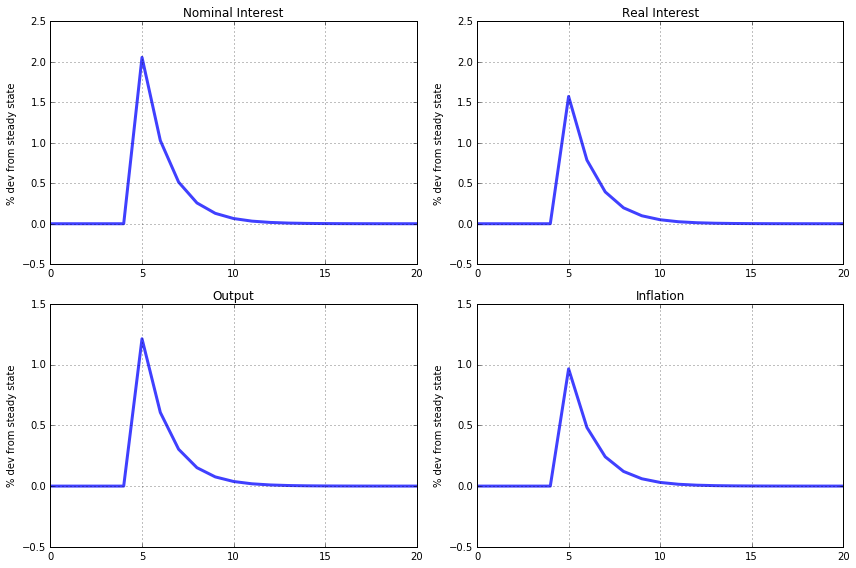

In [5]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
(nk_model.irs['e_g']['i']*400).plot(ax=ax1,lw=3,alpha=0.75,title='Nominal Interest',grid=True)
ax1.set_ylabel('% dev from steady state')

# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
(nk_model.irs['e_g']['r']*400).plot(ax=ax2,lw=3,alpha=0.75,title='Real Interest',grid=True)
ax2.set_ylabel('% dev from steady state')

# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
(nk_model.irs['e_g']['y']*100).plot(ax=ax3,lw=3,alpha=0.75,title='Output',grid=True)
ax3.set_ylabel('% dev from steady state')

# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)
(nk_model.irs['e_g']['pi']*400).plot(ax=ax4,lw=3,alpha=0.75,title='Inflation',grid=True)
ax4.set_ylabel('% dev from steady state')

ax1.set_ylim([-0.5,2.5])
ax2.set_ylim([-0.5,2.5])
ax3.set_ylim([-0.5,1.5])
ax4.set_ylim([-0.5,1.5])

fig.tight_layout()

### Inflation Shock

Plot the computed impulses responses of the nominal interest rate, the real interest rate, output, and inflation to the 0.01/4 unit inflation shock. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

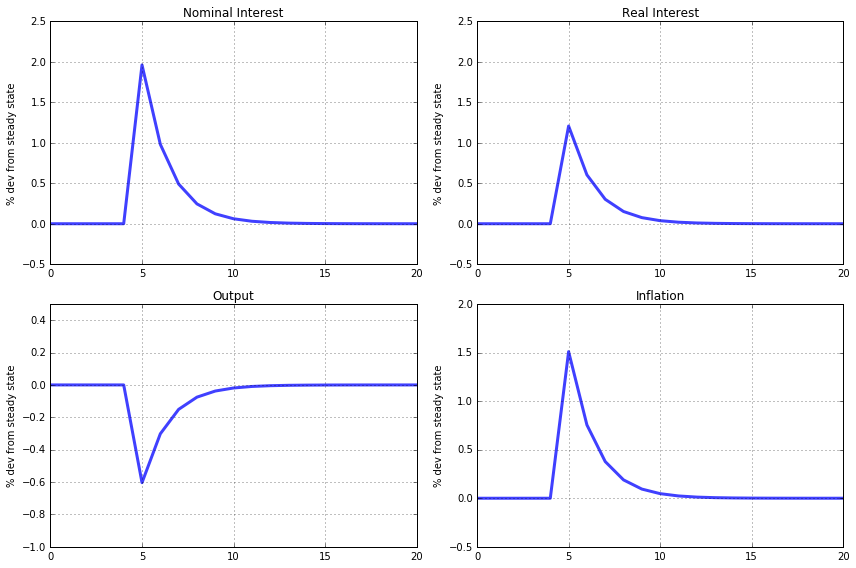

In [6]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
(nk_model.irs['e_u']['i']*400).plot(ax=ax1,lw=3,alpha=0.75,title='Nominal Interest',grid=True)
ax1.set_ylabel('% dev from steady state')

# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
(nk_model.irs['e_u']['r']*400).plot(ax=ax2,lw=3,alpha=0.75,title='Real Interest',grid=True)
ax2.set_ylabel('% dev from steady state')

# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
(nk_model.irs['e_u']['y']*100).plot(ax=ax3,lw=3,alpha=0.75,title='Output',grid=True)
ax3.set_ylabel('% dev from steady state')

# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)
(nk_model.irs['e_u']['pi']*400).plot(ax=ax4,lw=3,alpha=0.75,title='Inflation',grid=True)
ax4.set_ylabel('% dev from steady state')

ax1.set_ylim([-.5,2.5])
ax2.set_ylim([-0.5,2.5])
ax3.set_ylim([-1,0.5])
ax4.set_ylim([-0.5,2])

fig.tight_layout()

### Monetary Policy Shock

Plot the computed impulses responses of the nominal interest rate, the real interest rate, output, and inflation to the 0.01/4 unit monetary policy shock. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

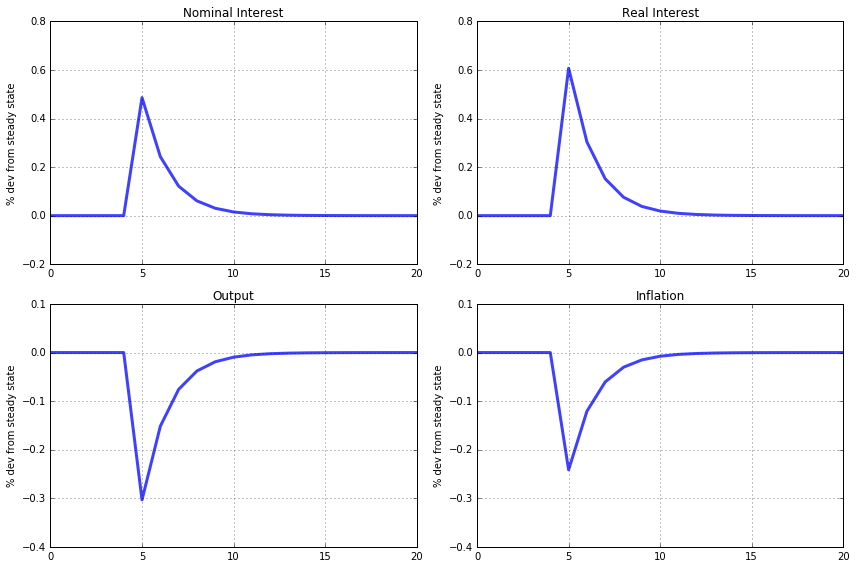

In [7]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
(nk_model.irs['e_v']['i']*400).plot(ax=ax1,lw=3,alpha=0.75,title='Nominal Interest',grid=True)
ax1.set_ylabel('% dev from steady state')

# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
(nk_model.irs['e_v']['r']*400).plot(ax=ax2,lw=3,alpha=0.75,title='Real Interest',grid=True)
ax2.set_ylabel('% dev from steady state')

# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
(nk_model.irs['e_v']['y']*100).plot(ax=ax3,lw=3,alpha=0.75,title='Output',grid=True)
ax3.set_ylabel('% dev from steady state')

# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)
(nk_model.irs['e_v']['pi']*400).plot(ax=ax4,lw=3,alpha=0.75,title='Inflation',grid=True)
ax4.set_ylabel('% dev from steady state')

ax1.set_ylim([-0.2,0.8])
ax2.set_ylim([-0.2,0.8])
ax3.set_ylim([-0.4,0.1])
ax4.set_ylim([-0.4,0.1])

fig.tight_layout()